In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
%config InlineBackend.figure_format = "retina"
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()
np.random.seed(107)

## `raw figure`

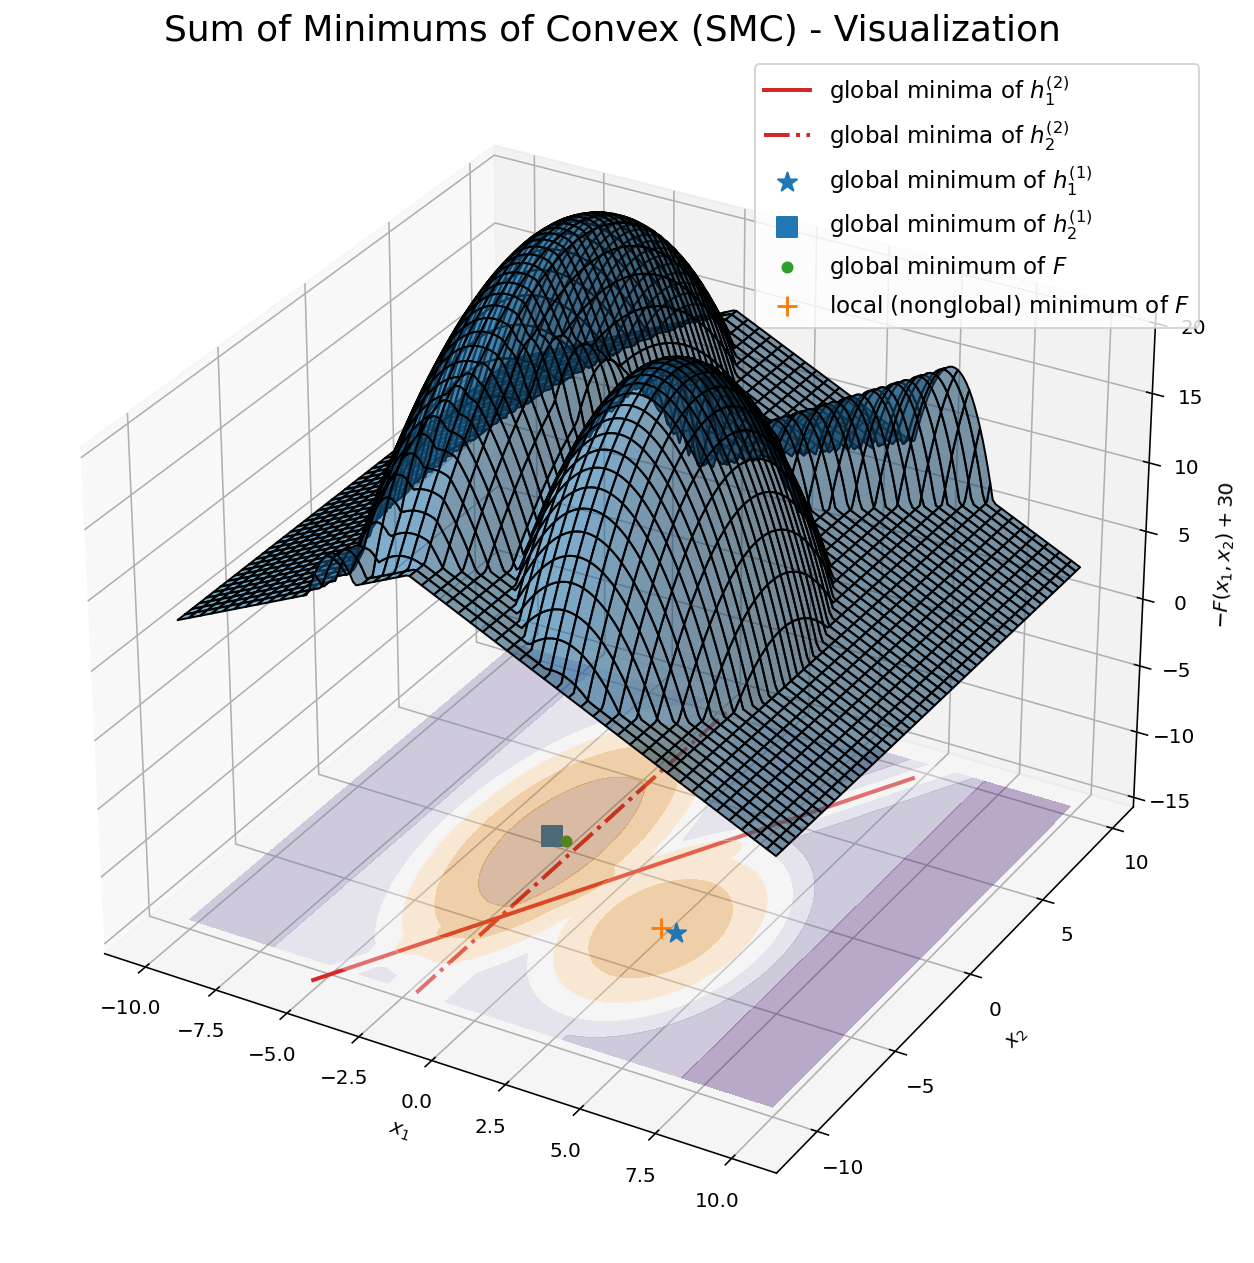

In [9]:
from mpl_toolkits.mplot3d import axes3d


ax = plt.figure(figsize=(11,11)).add_subplot(projection='3d')

plt.grid()
plt.title('Sum of Minimums of Convex (SMC) - Visualization',fontsize=18)
ncols,nrows=200,200

OFF = 15

x = np.linspace(-10, 10, ncols)
y = np.linspace(-10, 10, nrows)
X, Y = np.meshgrid(x, y)

Z = np.minimum(np.minimum(15,(X-3)**2+1/3*(Y+3)**2),(X+3)**2+1/6*Y**2)+ np.minimum((Y-2*X+1)**2,np.abs(X+2))


ax.plot_surface(X, Y, -Z+2*OFF, edgecolor='black',
               alpha=0.55)

ax.scatter([3], [-3], [-OFF],marker='*',s=100,color='tab:blue',label='global minimum of $h_1^{(1)}$')
ax.scatter([-3], [0], [-OFF],marker='s',s=100,color='tab:blue',label='global minimum of $h_2^{(1)}$')
ax.plot(np.linspace(-5,5,20), -1+2*np.linspace(-5,5,20), -OFF*np.ones(20),linewidth=2,color='tab:red',label='global minima of $h_1^{(2)}$')
ax.plot(-2*np.ones(20), np.linspace(-10,10,20), -OFF*np.ones(20),linewidth=2,color='tab:red',linestyle='-.',label='global minima of $h_2^{(2)}$')

ax.scatter([-5/2], [0], [-OFF],marker='.',s=100,color='tab:green',label='global minimum of $F$')
ax.scatter([5/2], [-3], [-OFF],marker='+',s=100,color='tab:orange',label='local (nonglobal) minimum of $F$')

ax.contourf(X, Y, Z, zdir='z', offset=-OFF,cmap='PuOr',alpha=0.35)


ax.set(zlim=(-15, 20),xlabel='$x_1$', ylabel='$x_2$', zlabel='$-F(x_1,x_2)+30$')
ax.legend(fontsize=11.5)
#ax.view_init(27,80)
plt.savefig('visu_SMC_paper.pdf',dpi=700)

## `max to min interpolation` (1D)

For every $i \in [n]$, $j \in [m_i]$,

$$x \to f_i^{(j)}(x) = \frac{Q_i{(j)}}{2}x^2 + q_i^{(j)}x + \kappa_i^{(j)}$$

for $Q_i^{(j)}\geq 0$, $q_i^{(j)},\, \kappa_i^{(j)} \in \mathbb{R}$. 

$$X = \mathcal{B}_{2,\rho}(0) = [-\rho,\rho]$$

In [ ]:
n = 10
rho = 4

automatic = True

if automatic:

    m_list,m_max,m_min = [],5,3

    Q_list,Q_max,Q_min = [],1,0
    q_list,q_max,q_min = [],3,-3
    kappa_list,kappa_max,kappa_min = [],1,-1

    for i in range(n):
        m_i = np.random.randint(m_min,m_max)
        m_list.append(m_i)
        Q_list.append(np.random.uniform(Q_min,Q_max,m_i))
        q_list.append(np.random.uniform(q_min,q_max,m_i))
        kappa_list.append(np.random.uniform(kappa_min,kappa_max,m_i))
        
else:
    
    Q_list = []
    q_list = []
    kappa_list = []
    m_list = [] 
    ... # @implement
    
### computation of M_i^{(j,k)}

M_bounds = []

for i in range(n):
    m_i = m_list[i]
    M_matrix_buf = np.zeros((m_i,m_i))
    Qis,qis,kappais = Q_list[i],q_list[i],kappa_list[i]
    for j in range(m_i):
        for k in range(m_i):
            if j!=k:
                Q_i_jk,q_i_jk,kappa_i_jk = Qis[j]-Qis[k],qis[j]-qis[k],kappais[j]-kappais[k]
                local_diff_jk = lambda x: 1/2*Q_i_jk*x**2 + q_i_jk*x + kappa_i_jk
                if Q_i_jk<0: # maximizer of concave @ min(rho,max(-rho,-Q_i_jk^(-1) q_i_jk))
                    x_min_i_jk = min(rho,max(-rho,-q_i_jk/Q_i_jk))
                    M_matrix_buf[j][k] = local_diff_jk(x_min_i_jk)
                else:
                    M_matrix_buf[j][k] = max(local_diff_jk(-rho),local_diff_jk(rho))
    M_bounds.append(M_matrix_buf)

In [ ]:
### closed-form expressions

def F(x,mode=None):
    f_i = []
    for i in range(n):
        f_i.append(mode([1/2*Q_list[i]*x**2+q_list[i]*x+kappa_list[i]]))
    return sum(f_i)
  

OUTSPAN = 2
N = 200
    
xs = np.linspace(-rho-OUTSPAN,rho+OUTSPAN,N)
Fs_min = np.array([F(x,np.min) for x in xs])
Fs_mean = np.array([F(x,np.mean) for x in xs])
Fs_max = np.array([F(x,np.max) for x in xs])

### CVX approach (not-optimized) 

C = cp.Parameter(1)
alphas = cp.Variable(n)
x_cvx = cp.Parameter(1)

obj = cp.sum(alphas)

constraints = []

t_variables = []

for i in range(n):
    t_variables.append(cp.Variable(m_list[i],boolean=True))
    constraints += [cp.sum(t_variables[-1])<=1]
    for j in range(m_list[i]):
        constraints += [1/2*Q_list[i][j]*x_cvx**2 + q_list[i][j]*x_cvx+kappa_list[i][j] \
                        <= alphas[i] + cp.sum(cp.multiply(C*M_bounds[i][j],t_variables[-1]))]

problem = cp.Problem(cp.Minimize(obj),constraints)

C_vals = [1e-1,1/4,3/4,1-1e-1]
x_vals = np.linspace(-rho,rho,N)
F_C_vals = []

for C_val in C_vals:
    C.value = np.array([C_val])
    print('loading with: C = '+str(C_val))
    buf = []
    for x in x_vals:
        x_cvx.value = np.array([x])
        problem.solve(solver=cp.MOSEK,warm_start=True)
        buf.append(problem.value)
    F_C_vals.append(np.array(buf))
    
### plots
plt.figure(figsize=(9,6))
plt.grid()
plt.xlabel('$x$')
plt.ylabel('value')
plt.title('Sum of Minimums of Convex (SMC) | max to min')
plt.plot(xs,Fs_min,linestyle='-',color='black',label='min')
plt.plot(xs,Fs_mean,linestyle='-.',color='black',label='mean')
plt.plot(xs,Fs_max,linestyle=':',color='black',label='max')
for idC,C_val in enumerate(C_vals):
    plt.plot(x_vals,F_C_vals[idC],linestyle='--',label='$C = $'+str(C_val))
plt.ylim([None,max(Fs_mean)])
plt.legend()
plt.savefig('interesting_enough.pdf',dpi=600)

In [ ]:
### optimal selection recovering at ...

true_selection = False

if true_selection:
    id_minimizer = np.argmin(Fs_min)
    value_minimizer = Fs_min[id_minimizer]
    minimizer = xs[id_minimizer]
else:
    minimizer = -2.9

j_elected_list = []

for i in range(n):
    val_i,j_elected = np.inf,0
    for j in range(m_list[i]):
        val_i_j = 1/2*Q_list[i][j]*minimizer**2 + q_list[i][j]*minimizer+kappa_list[i][j]
        if val_i_j<val_i:
            val_i = val_i_j
            j_elected = j
    j_elected_list.append((i,j_elected))
    
print(j_elected_list) # tuples i,j_i^*

In [ ]:
# L partition of indices
j_elected_list_shuffle = j_elected_list.copy()
np.random.shuffle(j_elected_list_shuffle)
L = 5
J_partition = np.array_split(j_elected_list_shuffle,L)

## ok validated as working => local minima unavoidable :')

In [ ]:
### second CVX approach (not-optimized) || TEST ||

alphas_2 = cp.Variable(n)
x_cvx_2 = cp.Variable(1)

obj_2 = cp.sum(alphas_2)

constraints_2 = []

t_variables_2 = []

for i in range(n):
    t_variables_2.append(cp.Variable(m_list[i],boolean=True))
    constraints_2 += [cp.sum(t_variables_2[-1])==1]
    for j in range(m_list[i]):
        constraints_2 += [1/2*Q_list[i][j]*x_cvx_2**2 + q_list[i][j]*x_cvx_2+kappa_list[i][j] \
                        <= alphas_2[i] + cp.sum(cp.multiply(M_bounds[i][j],t_variables_2[-1]))]   
        
for l_excluded in range(L):
    extra_constraints_l_excluded = []
    for l in range(L):
        if l!=l_excluded:
            for tup in J_partition[l]:
                i_tup,j_i_tup = tup[0],tup[1]
                extra_constraints_l_excluded.append(t_variables_2[i_tup][j_i_tup]==1)
                for k in range(m_list[i_tup]):
                    if k!=j_i_tup:
                        extra_constraints_l_excluded.append(t_variables_2[i_tup][k]==0)
    problem2 = cp.Problem(cp.Minimize(obj_2),constraints_2+extra_constraints_l_excluded)
    problem2.solve(solver=cp.MOSEK,warm_start=True)
    print('left-out portion l = '+str(l_excluded))
    print('subproblem l value: '+str(problem2.value))
    print('l-th -> x cvx = '+str(x_cvx_2.value))
    for t_var in t_variables_2:
        print(t_var.value)

In [ ]:
ran = np.arange(n)
np.random.shuffle(ran)
L_partition = np.array_split(ran,L)

In [ ]:
### third CVX approach (not-optimized) || TEST ||

ran = np.arange(n)
np.random.shuffle(ran)
L_partition = np.array_split(ran,L)

x_cvx_3 = cp.Variable(1)

rho_parameter = cp.Parameter(1,nonneg=True)

new_mean_x = np.zeros(1)

dic_x = {}
dic_val = {}
dic_t = {}

mode = 'central'

for l in range(L):
    dic_x[l] = []
    dic_val[l] = []
    dic_t[l] = {}
    for i in L_partition[l]:
        dic_t[l][i] = []

N_iters,tol_num,discrepancy = int(20),1e-5,np.inf

for iter_counter in range(N_iters):
        
    mean_x = new_mean_x.copy()
    new_mean_x = np.zeros(1)
    rho_parameter = cp.Parameter(1,nonneg=True)
    discrepancy_last = discrepancy
    
    print(' ')
    print('round #'+str(iter_counter))
    print(' ')
        
    for l in range(L):
        constraints_3 = []
        t_variables_3 = []
        alphas_3 = []
        obj_3 = 0
        for i_tup in L_partition[l]:
            alphas_3.append(cp.Variable(1))
            t_variables_3.append(cp.Variable(m_list[i_tup],boolean=True))
            obj_3 += cp.sum(alphas_3[-1]) 
            constraints_3 += [cp.sum(t_variables_3[-1])==1]
            for j in range(m_list[i_tup]):
                constraints_3 += [1/2*Q_list[i_tup][j]*x_cvx_3**2 + q_list[i_tup][j]*x_cvx_3+kappa_list[i_tup][j] \
                            <= alphas_3[-1] + cp.sum(cp.multiply(M_bounds[i_tup][j],t_variables_3[-1]))]  
                
        if iter_counter>0:
        
            if mode=='central':       
                for l_other in range(L):
                    prev_t = dic_t[l_other]
                    for i_other in L_partition[l_other]:
                        for j in range(m_list[i_other]):
                            if prev_t[i_other][j]>0.95:
                                obj_3 += 1/2*Q_list[i_other][j]*x_cvx_3**2 + q_list[i_other][j]*x_cvx_3+kappa_list[i_other][j]
            elif mode=='penalty':
                rho_parameter.value = np.array([5**iter_counter])
                obj_3 += rho_parameter * cp.sum_squares(x_cvx_3-mean_x)
                
            
        problem3_l = cp.Problem(cp.Minimize(obj_3),constraints_3)
        problem3_l.solve(solver=cp.MOSEK,verbose=False,warm_start=True)
        print('kept portion l = '+str(l))
        print('subproblem l value: '+str(problem3_l.value))
        print('l-th -> x cvx = '+str(x_cvx_3.value))
        dic_val[l] = problem3_l.value
        dic_x[l] = x_cvx_3.value
        for i_tup,t_var in zip(L_partition[l],t_variables_3):
            dic_t[l][i_tup] = t_var.value
            print('i = '+str(i_tup)+' and t_var = '+str(t_var.value))
            
        new_mean_x += 1/L * x_cvx_3.value
        
    discrepancy = 0
    for l in range(L):
        discrepancy += (1/L)*sum((dic_x[l]-new_mean_x)**2)
    discrepancy = np.sqrt(discrepancy)
    print('current discrepancy after iteration #'+str(iter_counter)+' : '+str(discrepancy))
    if discrepancy<=tol_num or abs(discrepancy-discrepancy_last)<1e-2*discrepancy:
        print(new_mean_x)
        break;